In [952]:
import csv
import pandas as pd
import numpy as np
#import filters  # THIS LIBRARY IS NOT INCLUDED IN THE REPOSITORY
import matplotlib.pyplot as pyp
import scipy.signal as signal
import numpy.fft as fft
import os         # ADD THIS SO WE CAN USE ENVIRONMENT VARIABLES
import matplotlib
from scipy.optimize import curve_fit
import scipy.optimize
from scipy.interpolate import interp1d
%matplotlib inline

#print os.environ
print os.environ.get('TAU_ACC_ZHAIRES_DIR')
#print os.environ['TAU_ACC_ZHAIRES_DIR']

/Users/wissels/Dropbox/MountainTop/harms_sims/npz_files/


In [705]:
pastel_colors = ['#FF6666','#FFCC66','#CCFF66','#66FF66','#66FFCC','#66FFFF','#66CCFF','#6666FF','#CC66FF','#FF66FF','#FF6FCF']
bright_colors = ['#FF0000','#FF8000','#FFFF00','#80FF00','#00FF00','#00FF80','#00FFFF','#0080FF','#0000FF','#8000FF','#FF00FF']
bright_colors2 = bright_colors = ['#FF0000','#FF8000','#80FF00','#00FF80','#0080FF','#0000FF','#8000FF','#FF00FF','#FF0080']
pyp.rcParams['font.size']=18
pyp.rcParams['legend.labelspacing'] = 0.1

In [706]:
#### Should move this to a library

In [707]:
def temp(f_MHz):
    # Dulk 2001
    nu = f_MHz # Hz
    tau = 5.0 * pow(nu, -2.1)
    Ieg = 1.0610e-20
    Ig  = 2.48e-20
    # Iv in  W/m^2/Hz/sr
    Iv = Ig * pow(nu, -0.52) * (1-np.exp(-tau))/tau + Ieg * pow(nu, -0.80) * np.exp(-tau)
    
    kB = 1.38064852e-23 # Watts / Hz / K
    c = 299792458 # m/s
    temp = Iv * c**2 / (2*(nu*1e6)**2)/kB

    return Iv, temp # W/m^2/Hz/sr, K

def read_npz_files(antenna_height, zenith):
    npzfile = np.load(os.environ['TAU_ACC_ZHAIRES_DIR'] + "/" + "altitude_%dkm_zenith_%d.npz"%(antenna_height, zenith))
    efield_td = npzfile['efield_td'][()] ## for some reason just reading the arrays gives a 0-dim array, so skip this.
    efield_fd = npzfile['efield_fd'][()]
    return efield_td, efield_fd

In [708]:
# WANT TO PARAMETERIZE THE EFIELDS AT ALL ZENITH ANGLES 
# FOLLOWING TECHNIQUE USED FOR ANITA
# WE WILL HAVE TO CHOOSE A FEW BANDS OF INTEREST BASED ON
# RESULTS FROM EFIELD_PULSES_ANGULAR_ACCEPTANCE
# this is for E=1.e17

def band_peak_efield(efield, freq, f_LO, bandwidth):
    df = freq[1]-freq[0]
    cut = np.logical_and(freq>=f_LO, freq<=f_LO + bandwidth)
    return np.sum(np.abs(efield[cut]))*df

def efield_vs_angle(h, z, f_Lo_list, bandwidth_list):

    off_angle_array = np.arange(0.04,80*0.04, 0.04)
    i_off_angle_array = range(1, len(off_angle_array)+1)
    epeak_list = np.zeros((len(f_Lo_list), len(bandwidth_list), len(i_off_angle_array)))
    cc = 0
    for i_offangle in i_off_angle_array:
        #if(i_offangle%10==0): print i_offangle
        offangle = off_angle_array[i_offangle-1]
        efield_td, efield_fd = read_npz_files(h,z)
        efield = efield_td[i_offangle]['y_v_per_m']
        time = efield_td[i_offangle]['time_s']
        time -= time[0]
        dt = time[1]-time[0]
        E_fft = np.fft.rfft(efield)*dt*1.e6 # use dt in µs so that fft is in units of V/m/MHz
        fr = np.fft.rfftfreq(len(efield), dt*1.e6) # frequencies in MHz
        for i_f_Lo in range(0,len(f_Lo_list)):
            f_Lo = f_Lo_list[i_f_Lo]
            for i_bandwidth in range(0,len(bandwidth_list)):
                bandwidth = bandwidth_list[i_bandwidth]
                epeak_list[i_f_Lo, i_bandwidth, cc] = band_peak_efield(E_fft, fr, f_Lo, bandwidth)
        cc+=1
    #pyp.figure(3)
    #pyp.plot(off_angle_array, voltage_SNR, 'ko')
    return off_angle_array, epeak_list

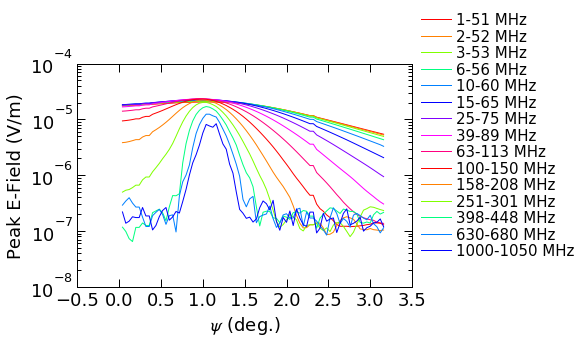

In [709]:
h = 2
z = 85
f_Lo_list = 10**np.arange(0.2,3.2,0.2)
bandwidth_list = np.array([50])
psi, epeak_list = efield_vs_angle(h, z, f_Lo_list, bandwidth_list)


for i_f_Lo in range(0,len(f_Lo_list)):
    f_Lo = f_Lo_list[i_f_Lo]
    for i_bandwidth in range(0,len(bandwidth_list)):
        bandwidth = bandwidth_list[i_bandwidth]
        pyp.semilogy(psi, epeak_list[i_f_Lo, i_bandwidth,:], 
                     bright_colors2[i_f_Lo%9], label="%d-%d MHz"%(int(f_Lo), int(f_Lo) + int(bandwidth)))

pyp.xlabel("$\psi$ (deg.)")        
pyp.ylabel("Peak E-Field (V/m)")
pyp.legend(loc=[1.01, 0.1])

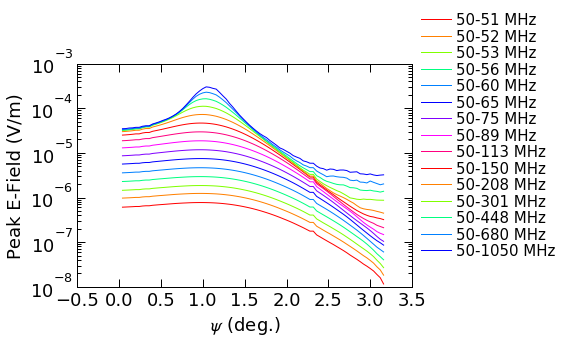

In [710]:
f_Lo_list = np.array([50])
bandwidth_list = 10**np.arange(0.2,3.2,0.2)
psi, epeak_list = efield_vs_angle(h, z, f_Lo_list, bandwidth_list)


for i_f_Lo in range(0,len(f_Lo_list)):
    f_Lo = f_Lo_list[i_f_Lo]
    for i_bandwidth in range(0,len(bandwidth_list)):
        bandwidth = bandwidth_list[i_bandwidth]
        pyp.semilogy(psi, epeak_list[i_f_Lo, i_bandwidth,:], 
                     bright_colors2[i_bandwidth%9], label="%d-%d MHz"%(int(f_Lo), int(f_Lo) + int(bandwidth)))

pyp.xlabel("$\psi$ (deg.)")        
pyp.ylabel("Peak E-Field (V/m)")
pyp.legend(loc=[1.01, 0.1])

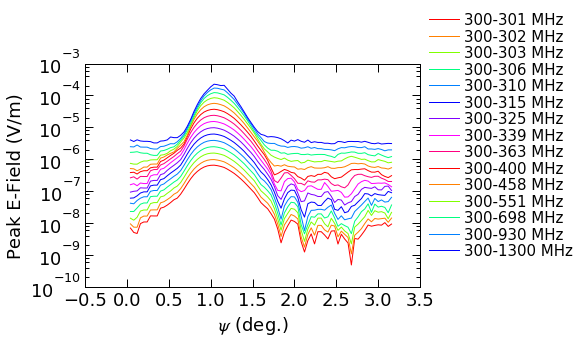

In [711]:
f_Lo_list = np.array([300])
bandwidth_list = 10**np.arange(0.2,3.2,0.2)
psi, epeak_list = efield_vs_angle(h, z, f_Lo_list, bandwidth_list)

for i_f_Lo in range(0,len(f_Lo_list)):
    f_Lo = f_Lo_list[i_f_Lo]
    for i_bandwidth in range(0,len(bandwidth_list)):
        bandwidth = bandwidth_list[i_bandwidth]
        pyp.semilogy(psi, epeak_list[i_f_Lo, i_bandwidth,:], 
                     bright_colors2[i_bandwidth%9], label="%d-%d MHz"%(int(f_Lo), int(f_Lo) + int(bandwidth)))

pyp.xlabel("$\psi$ (deg.)")        
pyp.ylabel("Peak E-Field (V/m)")
pyp.legend(loc=[1.01, 0.1])

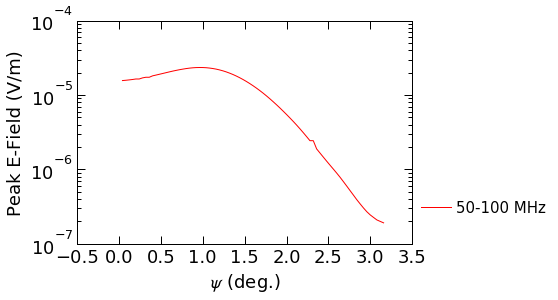

In [712]:
f_Lo_list = np.array([50])
bandwidth_list = np.array([50])
psi, epeak_list = efield_vs_angle(h, z, f_Lo_list, bandwidth_list)

for i_f_Lo in range(0,len(f_Lo_list)):
    f_Lo = f_Lo_list[i_f_Lo]
    for i_bandwidth in range(0,len(bandwidth_list)):
        bandwidth = bandwidth_list[i_bandwidth]
        pyp.semilogy(psi, epeak_list[i_f_Lo, i_bandwidth,:], 
                     bright_colors2[i_bandwidth%9], label="%d-%d MHz"%(int(f_Lo), int(f_Lo) + int(bandwidth)))

pyp.xlabel("$\psi$ (deg.)")        
pyp.ylabel("Peak E-Field (V/m)")
pyp.legend(loc=[1.01, 0.1])



In [929]:
def airshower_beam_func(psi, E_0, frac_gauss, gauss_peak, gauss_width, E_1, width2):
    v = (psi - gauss_peak) / gauss_width
    E_field = E_0*(frac_gauss*np.exp(-v**2/2.) \
                   + (1-frac_gauss)/(1+v**2)) \
                   + E_1*np.exp(-psi**2/2./width2**2)
    return E_field

def lorentzian_func(psi, E_0, frac_gauss, gauss_peak, gauss_width):
    v = (psi - gauss_peak) / gauss_width
    E_field = E_0*(frac_gauss*np.exp(-v**2/2.)  + (1-frac_gauss)/(1+v**2))
    return E_field

def lorentzian_gaussian_background_func(psi, E_0, frac_gauss, gauss_peak, gauss_width, E_1, width2):
    v = (psi - gauss_peak) / gauss_width
    E_field = E_0*(frac_gauss*np.exp(-v**2/2.)  + (1-frac_gauss)/(1+v**2)) + E_1*np.exp(-psi**2/2./width2**2)
    #E_field = E_1*(frac_gauss*np.exp(-psi**2/(2.*width2) )) + E_0 * (1-frac_gauss) /(width2*(1. + (v/width2)**2))
    
    return E_field

(0, 0.00025000000000000001)

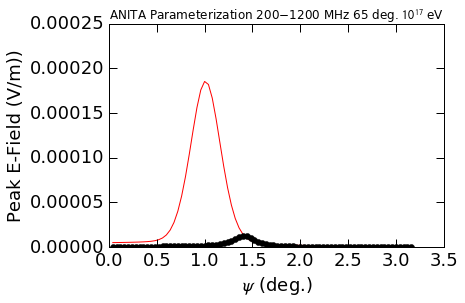

In [714]:
E_0  = 0.183*1.e-3     # V/m at ground level for 10^17 eV tau lepton.
gauss_peak = 1.01 # degrees
gauss_width = 0.160          # degrees
E_1 = 0.00385*1.e-3    # V/m at ground level for 10^17 eV tau lepton.
width2 = 1.14          # degrees
frac_gauss = 0.825 # fraction of Gaussian peak ( 1-frac_gauss is lorentzian)

test = airshower_beam_func(psi, E_0, frac_gauss, gauss_peak, gauss_width, E_1, width2)

h=37
z=87
f_Lo_list = np.array([200])
bandwidth_list = np.array([1000])
psi, epeak_list = efield_vs_angle(h, z, f_Lo_list, bandwidth_list)

pyp.plot(psi, test, 'r')
pyp.plot(psi, epeak_list[0,0,:], 'ko')
pyp.title("ANITA Parameterization 200-1200 MHz 65 deg. $10^{17}$ eV", fontsize=12)
pyp.ylabel("Peak E-Field (V/m))")
pyp.xlabel("$\psi$ (deg.)")
pyp.xlim(0)
pyp.ylim(0)

INITIAL PARAMETERS: 
_____________________
[0.000183, 0.825, 1.4400000000000002, 0.16, 3.85e-06, 1.14]
_____________________
FIT PARAMETERS: 
_____________________
[  8.89280454e-05   5.54764860e-01   1.27490910e+00   1.89992406e-01
   9.05121850e-07  -4.48552258e-01]
_____________________
1.81797309828e-06
8.89322341301e-05


(3.9815004289048663e-07, 0.0001)

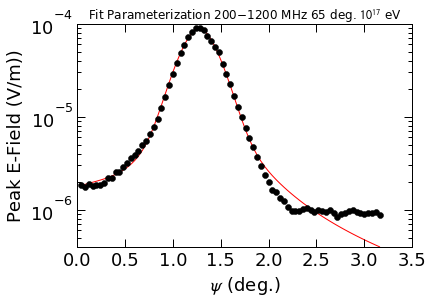

In [715]:
# Use ANITA parameterization to test the curve fit. 
# NOTE: SHIFTING FROM 1.01 deg to peak in the efield.
# Fit fails if initial parameter for gauss_peak is not close

E_0  = 0.183*1.e-3     # V/m at ground level for 10^17 eV tau lepton.
gauss_peak = psi[np.where(max(epeak_list[0][0]) == epeak_list[0][0][:])[0][0]]      # degree. 
gauss_width = 0.160          # degrees
E_1 = 0.00385*1.e-3    # V/m at ground level for 10^17 eV tau lepton.
width2 = 1.14          # degrees
frac_gauss = 0.825 # fraction of Gaussian peak ( 1-frac_gauss is lorentzian)
p0 = [E_0, frac_gauss, gauss_peak, gauss_width, E_1, width2] # initial parameters for the curve fit.

print "INITIAL PARAMETERS: "
print "_____________________"
print p0
print "_____________________"

h=37
z=60
f_Lo_list = np.array([200])
bandwidth_list = np.array([1000])
psi, epeak_list = efield_vs_angle(h, z, f_Lo_list, bandwidth_list)
popt, pcov = curve_fit(airshower_beam_func, psi, epeak_list[0,0,:], p0=p0)
print "FIT PARAMETERS: "
print "_____________________"
print popt
print "_____________________"

print epeak_list[0,0,0]
print max(epeak_list[0,0,:])
pyp.semilogy(psi, airshower_beam_func(psi, *popt), 'r')
pyp.plot(psi, epeak_list[0,0,:], 'ko')
pyp.title("Fit Parameterization 200-1200 MHz 65 deg. $10^{17}$ eV", fontsize=12)
pyp.ylabel("Peak E-Field (V/m))")
pyp.xlabel("$\psi$ (deg.)")
pyp.xlim(0)
pyp.ylim(0)

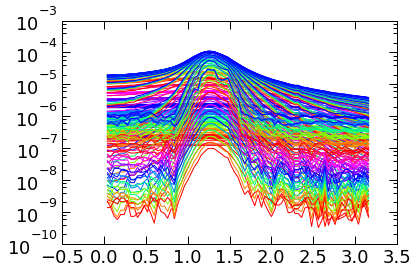

In [716]:
# Loading the files and calculating the peak e-fields are slow, so do it once
f_Lo_list = 10**np.arange(0.2,3.2,0.2)
bandwidth_list = 10**np.arange(0.2,3.2,0.2)
psi, epeak_list = efield_vs_angle(h, z, f_Lo_list, bandwidth_list)

for i_f_Lo in range(0,len(f_Lo_list)):
    f_Lo = f_Lo_list[i_f_Lo]
    for i_bandwidth in range(0,len(bandwidth_list)):
        bandwidth = bandwidth_list[i_bandwidth]
        pyp.semilogy(psi, epeak_list[i_f_Lo, i_bandwidth,:], bright_colors2[i_bandwidth%9])

In [717]:
# use for finding the inital parameters for the fit
def FWHM(X,Y):
    half_max = max(Y) / 2.
    max_ind = np.where(Y==max(Y))[0][0]
    under_half_max_ind = np.where(Y<half_max)[0]

    if( len(under_half_max_ind) == 0):
        return abs((X[-1] - X[0]))
    elif( under_half_max_ind.all() < max_ind):
        return 2*abs((X[max_ind] - X[under_half_max_ind[-1]]))
    
   
    
    #find when function crosses line half_max (when sign of diff flips)
    #take the 'derivative' of signum(half_max - Y[])
    d = np.sign(half_max - np.array(Y[0:-1])) - np.sign(half_max - np.array(Y[1:]))
    pyp.figure(1)
    pyp.plot(X,Y)
    pyp.figure(2)
    pyp.plot(X[:-1],d) #if you are interested
    #find the left and right most indexes
    left_idx = np.where(d > 0)[0]
    right_idx = np.where(d < 0)[-1]
    print left_idx, right_idx
    if( len(left_idx) == 0):
        left_idx = 0
    else:
        left_idx = left_idx[0]
    if( len(right_idx)== 0):
        right_idx = len(d) - 1
    else:
        right_idx = right_idx[0]
    print left_idx, right_idx
    return X[right_idx] - X[left_idx] #return the difference (full width)

Bandwidth :  630.95734448


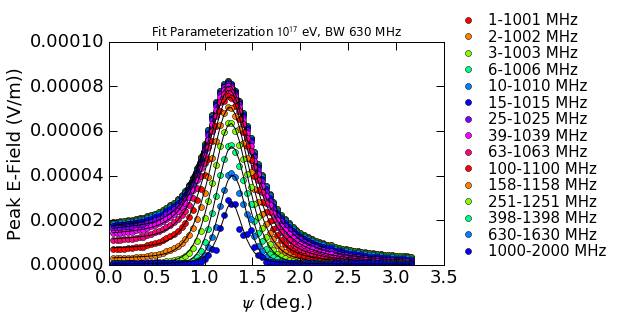

In [718]:
# Fit curves by varying the starting frequency for a fixed bandwidth.
# Fit fails if initial parameter for gauss_peak is not close
i_bandwidth  = 13
print "Bandwidth : ", bandwidth_list[i_bandwidth]

for i_f_Lo in range(0,len(f_Lo_list)):
    f_Lo = f_Lo_list[i_f_Lo]
    E_0  =  max(epeak_list[i_f_Lo][i_bandwidth])# V/m at ground level for 10^17 eV tau lepton.
    E_1 = epeak_list[i_f_Lo][i_bandwidth][0]   # V/m at ground level for 10^17 eV tau lepton.
    frac_gauss = E_1/E_0 # fraction of Gaussian peak ( 1-frac_gauss is lorentzian)

    p0 = [E_0, frac_gauss, gauss_peak, gauss_width, E_1, width2] # initial parameters for the curve fit.
    popt, pcov = curve_fit(lorentzian_gaussian_background_func, psi, epeak_list[i_f_Lo,i_bandwidth,:], p0=p0)
    pyp.plot(psi, epeak_list[i_f_Lo, i_bandwidth,:], 'o', color = bright_colors2[i_f_Lo%9], label="%d-%d MHz"%(int(f_Lo), int(f_Lo + bandwidth)))
    pyp.plot(psi, airshower_beam_func(psi, *popt),  'k')
    pyp.title("Fit Parameterization $10^{17}$ eV, BW %d MHz"%(int(bandwidth_list[i_bandwidth])), fontsize=12)
pyp.ylabel("Peak E-Field (V/m))")
pyp.xlabel("$\psi$ (deg.)")
pyp.xlim(0)
pyp.ylim(0)
pyp.legend(loc=[1.01,0.0])
pyp.savefig(os.environ['TAU_ACC_DETECTOR_PLOTS_DIR'] + "/efield_BW_%dMHz_altitude%dkm_ze%d.png"%(int(bandwidth_list[i_bandwidth]), h, z))

Starting Frequency :  39.8107170553


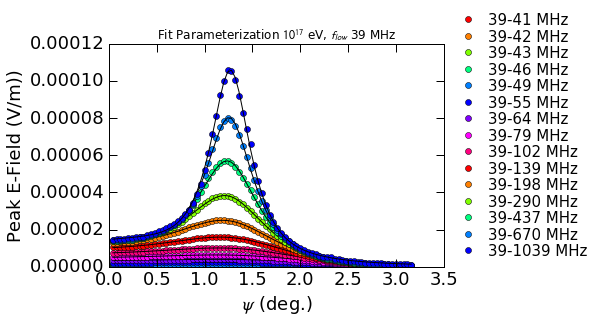

In [719]:
# Fit curves using a starting frequency of 39 MHz and varying the bandwidth.
# Using the initial parameters from the ANITA curve fit above 
# BUT finding the peak for each curve.
# NOTE: SHIFTING FROM 1.01 deg to peak in the efield.
# Fit fails if initial parameter for gauss_peak is not close
i_f_Lo = 7
f_Lo = f_Lo_list[i_f_Lo]
print "Starting Frequency : ", f_Lo_list[i_f_Lo]

for i_bandwidth in range(0,len(bandwidth_list)):
    bandwidth = bandwidth_list[i_bandwidth]
    E_0  =  max(epeak_list[i_f_Lo][i_bandwidth])# V/m at ground level for 10^17 eV tau lepton.
    E_1 = epeak_list[i_f_Lo][i_bandwidth][0]   # V/m at ground level for 10^17 eV tau lepton.
    frac_gauss = E_1/E_0 # fraction of Gaussian peak ( 1-frac_gauss is lorentzian)

    p0 = [E_0, frac_gauss, gauss_peak, gauss_width, E_1, width2] # initial parameters for the curve fit.
    #print "INITIAL PARAMETERS: "
    #print "_____________________"
    #print p0
    #print "_____________________"
    popt, pcov = curve_fit(lorentzian_gaussian_background_func, psi, epeak_list[i_f_Lo,i_bandwidth,:], p0=p0)
    pyp.plot(psi, epeak_list[i_f_Lo, i_bandwidth,:], 'o', color = bright_colors2[i_bandwidth%9], label="%d-%d MHz"%(int(f_Lo), int(f_Lo + bandwidth)))
    pyp.plot(psi, airshower_beam_func(psi, *popt),  'k')
    #print "FIT PARAMETERS: "
    #print "_____________________"
    #print popt
    #print "_____________________"
pyp.title("Fit Parameterization $10^{17}$ eV, $f_{low}$ %d MHz"%(int(f_Lo_list[i_f_Lo])), fontsize=12)
pyp.ylabel("Peak E-Field (V/m))")
pyp.xlabel("$\psi$ (deg.)")
pyp.xlim(0)
pyp.ylim(0)
pyp.legend(loc=[1.01,0.01])
pyp.savefig(os.environ['TAU_ACC_DETECTOR_PLOTS_DIR'] + "/efield_flow_%dMHz_altitude%dkm_ze%d.png"%(int(f_Lo_list[i_f_Lo]),h,z) )

In [831]:
h = 37
zenith_list = np.array([60, 70, 75, 80, 85, 87])
f_Lo_list = np.arange(10., 1610., 10.)
bandwidth_list = np.array([10.])

epeak_array = []
for z in zenith_list:
    psi, epeak_list = efield_vs_angle(h, z, f_Lo_list, bandwidth_list)
    epeak_array.append(epeak_list)
    
epeak_array = np.array(epeak_array)

Bandwidth :  10.0


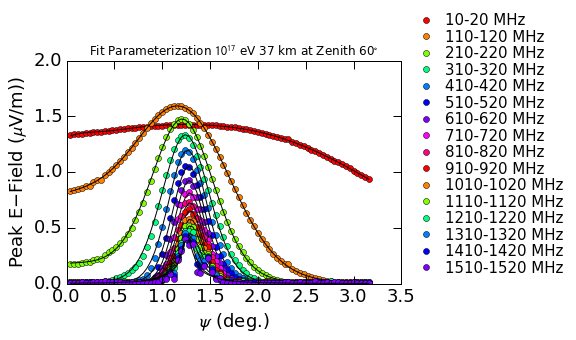

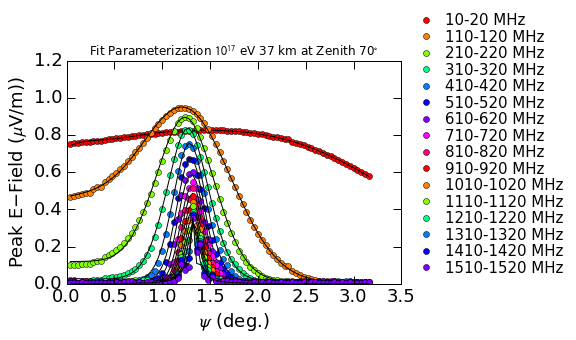

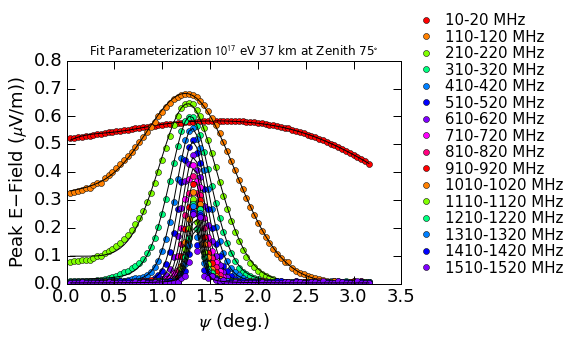

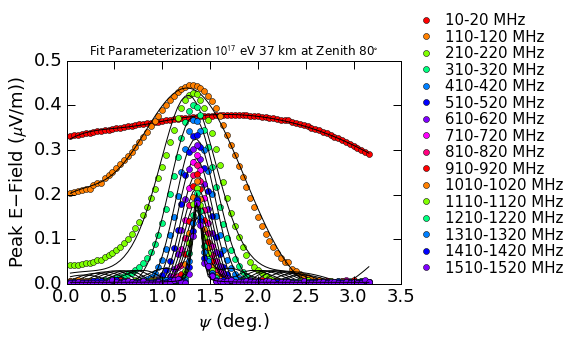

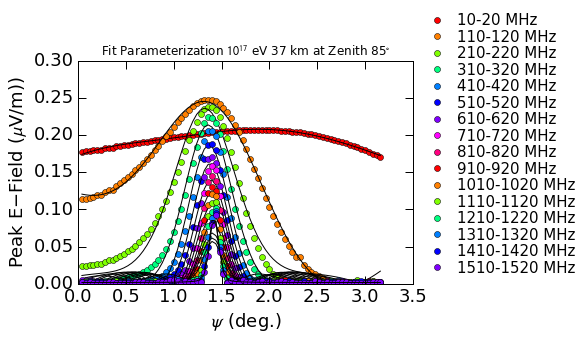

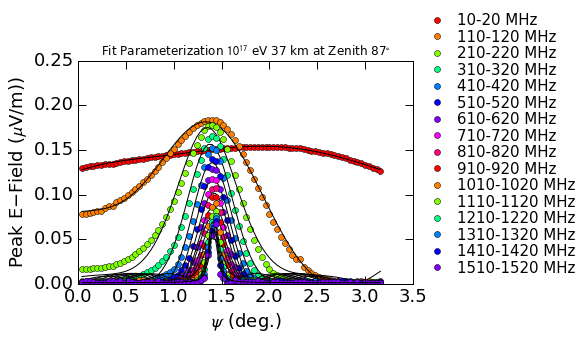

In [832]:
# Fit curves using a starting frequency of 25 MHz and varying the bandwidth.
# Using the initial parameters from the ANITA curve fit above 
# BUT finding the peak for each curve.
# NOTE: SHIFTING FROM 1.01 deg to peak in the efield.
# Fit fails if initial parameter for gauss_peak is not close
#### This set of initial parameters works for the h=37km files
i_bandwidth = 0
bandwidth = bandwidth_list[i_bandwidth]
print "Bandwidth : ", bandwidth

#i_ze = 5
#z = zenith_list[i_ze]

curve_fit_parameters = np.zeros((len(zenith_list), len(f_Lo_list), 6))
for i_ze in range(0, len(zenith_list)):
    pyp.figure()
    for i_f_Lo in range(0,len(f_Lo_list)):
        f_Lo = f_Lo_list[i_f_Lo]
        E_0  =  max(epeak_array[i_ze][i_f_Lo][i_bandwidth])# V/m at ground level for 10^17 eV tau lepton.
        E_1 = epeak_array[i_ze][i_f_Lo][i_bandwidth][0]   # V/m at ground level for 10^17 eV tau lepton.
        frac_gauss = E_1/E_0 # fraction of Gaussian peak ( 1-frac_gauss is lorentzian)
        gauss_peak = psi[np.where(max(epeak_array[i_ze][i_f_Lo][i_bandwidth]) == epeak_array[i_ze][i_f_Lo][i_bandwidth][:])[0][0]]      # degree. 
        
        if( i_f_Lo == 0):
            gauss_width = FWHM(psi, epeak_array[i_ze][i_f_Lo][i_bandwidth][:])
            width2 = 0.05
            p0 = [E_0, frac_gauss, gauss_peak, gauss_width, E_1, width2] # initial parameters for the curve fit.
        else:
            # Use the last gaussian and lorentzian widths to seed the fit.
            # The fit is sensitive to the individual frac_gauss, E_0, and E_1, but the widths are changing slowly.
            gauss_width = FWHM(psi, epeak_array[i_ze][i_f_Lo][i_bandwidth][:])
            p0 = popt
            p0[0] = E_0
            p0[2] = gauss_peak
            p0[4] = E_1*0.1
            
        popt, pcov = curve_fit(lorentzian_gaussian_background_func, psi, epeak_array[i_ze, i_f_Lo,i_bandwidth,:], p0=p0)
        curve_fit_parameters[i_ze, i_f_Lo, :] = popt
        if( i_f_Lo % 10 == 0):
            pyp.plot(psi, epeak_array[i_ze,i_f_Lo, i_bandwidth,:]*1e6, 'o', color = bright_colors2[i_f_Lo%9], label="%d-%d MHz"%(int(f_Lo), int(f_Lo + bandwidth)))

            pyp.plot(psi, lorentzian_gaussian_background_func(psi, *popt)*1e6,  'k')

    pyp.title("Fit Parameterization $10^{17}$ eV %d km at Zenith %d$^{\circ}$"%(h, int(zenith_list[i_ze])), fontsize=12)
    pyp.ylabel("Peak E-Field ($\mu$V/m))")
    pyp.xlabel("$\psi$ (deg.)")
    pyp.xlim(0)
    pyp.ylim(0)
    pyp.legend(loc=[1.01,0.01])
    pyp.savefig(os.environ['TAU_ACC_DETECTOR_PLOTS_DIR'] + "/efield_eparms_altitude%dkm_ze%d.png"%(h,int(zenith_list[i_ze])) )

In [834]:
fit_file = open(os.environ['TAU_ACC_ZHAIRES_DIR']+'/curve_fits_%dkm.npz'%h, 'w')
np.savez(fit_file, curve_fit_parms=curve_fit_parameters, zenith_list=zenith_list, bandwidth=10., f_Lo_list = f_Lo_list)
fit_file.close()
print np.shape(curve_fit_parameters)

(6, 160, 6)


In [956]:
h = 1
zenith_list = np.array([60, 70, 75, 80, 85, 87])
f_Lo_list = np.arange(10., 1610., 10.)
bandwidth_list = np.array([10.])

epeak_array = []
for z in zenith_list:
    psi, epeak_list = efield_vs_angle(h, z, f_Lo_list, bandwidth_list)
    epeak_array.append(epeak_list)
    
epeak_array = np.array(epeak_array)

In [ ]:
#########
# Backup. This is cludgy, but works. However, the fit parameters are varying widely.
###
## Try to make it more robust in next cell
##
###
# Fit curves using a starting frequency of 25 MHz and varying the bandwidth.
# Using the initial parameters from the ANITA curve fit above 
# BUT finding the peak for each curve.
# NOTE: SHIFTING FROM 1.01 deg to peak in the efield.
# Fit fails if initial parameter for gauss_peak is not close
#### This set works for the 1 km altitude
i_bandwidth = 0
bandwidth = bandwidth_list[i_bandwidth]
print "Bandwidth : ", bandwidth

#i_ze = 5
#z = zenith_list[i_ze]

curve_fit_parameters = np.zeros((len(zenith_list), len(f_Lo_list), 6))
for i_ze in range(0, len(zenith_list)):
    pyp.figure(i_ze+1)
    print "Zenith", zenith_list[i_ze]
    for i_f_Lo in range(0,len(f_Lo_list)):
        f_Lo = f_Lo_list[i_f_Lo]
        E_0  =  max(epeak_array[i_ze][i_f_Lo][i_bandwidth])# V/m at ground level for 10^17 eV tau lepton.
        E_1 = epeak_array[i_ze][i_f_Lo][i_bandwidth][-1]   # V/m at ground level for 10^17 eV tau lepton.
        frac_gauss = E_1/E_0 # fraction of Gaussian peak ( 1-frac_gauss is lorentzian)
        gauss_peak = psi[np.where(max(epeak_array[i_ze][i_f_Lo][i_bandwidth]) == epeak_array[i_ze][i_f_Lo][i_bandwidth][:])[0][0]]      # degree. 
        if( i_f_Lo == 0):
            gauss_width = FWHM(psi, epeak_array[i_ze][i_f_Lo][i_bandwidth][:])
            width2 = 0.05
            p0 = [E_0, frac_gauss, gauss_peak, gauss_width, E_1, width2] # initial parameters for the curve fit.
        else:
            # Use the last gaussian and lorentzian widths to seed the fit.
            # The fit is sensitive to the individual frac_gauss, E_0, and E_1, but the widths are changing slowly.
            #     gauss_width = FWHM(psi, epeak_array[i_ze][i_f_Lo][i_bandwidth][:])
            p0 = popt
        
        if( gauss_peak < gauss_width/2. and i_ze<1 ):
            #Supress the Lorentzian and fit with a gaussian
            p0 = [E_0*0.05, p0[1], 0.0, p0[2], p0[4], p0[5]]
            #p0[2] = 0.#gauss_peak
            
            #if( frac_gauss < 0.05):
            #p0[4] = E_1*0.1
        #print "INITIAL PARAMETERS: "
        #print "_____________________"
        #print p0
        #print "_____________________"
        #print i_f_Lo, frac_gauss, p0
        #
        #pyp.plot(psi, lorentzian_gaussian_background_func(psi, *p0)*1e6,  'b')
        #pyp.plot(psi, epeak_array[i_ze,i_f_Lo, i_bandwidth,:]*1e6, 'o', color = bright_colors2[i_f_Lo%9], label="%d-%d MHz"%(int(f_Lo), int(f_Lo + bandwidth)))
        try:
            popt, pcov = curve_fit(lorentzian_gaussian_background_func, psi, epeak_array[i_ze, i_f_Lo,i_bandwidth,:], p0=p0)
        except:
            print "Fit failed, trying again"
            #p0 = popt
            if( i_ze == 0):
                p0 = popt
            else:
                p0 = curve_fit_parameters[i_ze-1, i_f_Lo, :]
                p0[0] = E_0
                p0[4] = E_1
            print "p0", p0
            popt, pcov = curve_fit(lorentzian_gaussian_background_func, psi, epeak_array[i_ze, i_f_Lo,i_bandwidth,:], p0=p0)
        #popt = abs(popt)
        #popt, pcov = curve_fit(lorentzian_gaussian_background_func, psi, epeak_array[i_ze, i_f_Lo,i_bandwidth,:], p0=p0)
        curve_fit_parameters[i_ze, i_f_Lo, :] = popt
        if( i_f_Lo % 10 == 0):
            pyp.figure(i_ze+1)
            pyp.plot(psi, epeak_array[i_ze,i_f_Lo, i_bandwidth,:]*1e6, 'o', color = bright_colors2[i_f_Lo%9], label="%d-%d MHz"%(int(f_Lo), int(f_Lo + bandwidth)))
            #popt = abs(popt)
            pyp.plot(psi, lorentzian_gaussian_background_func(psi, *popt)*1e6,  'k')
        #if( i_f_Lo % 10 == 0):    
        #    print "FIT PARAMETERS: "
        #    print "_____________________"
        #    print popt
        #    print "_____________________"
    pyp.figure(i_ze+1)
    print "Zenith", zenith_list[i_ze], i_ze
    pyp.title("Fit Parameterization $10^{17}$ eV at %d km Zenith %d$^{\circ}$"%(h, zenith_list[i_ze]), fontsize=12)
    print "Zenith", zenith_list[i_ze], i_ze
    pyp.ylabel("Peak E-Field ($\mu$V/m))")
    pyp.xlabel("$\psi$ (deg.)")
    pyp.xlim(0)
    pyp.ylim(0,1.2*epeak_array[i_ze,:, i_bandwidth,:].max()*1e6)
    pyp.legend(loc=[1.01,0.01])
    pyp.savefig(os.environ['TAU_ACC_DETECTOR_PLOTS_DIR'] + "/efield_eparms_altitude%dkm_ze%d.png"%(h,int(zenith_list[i_ze])) )

In [838]:
fit_file = open(os.environ['TAU_ACC_ZHAIRES_DIR']+'/curve_fits_%dkm.npz'%h, 'w')
np.savez(fit_file,  curve_fit_parms=curve_fit_parameters, zenith_list=zenith_list, bandwidth=10., f_Lo_list = f_Lo_list)
fit_file.close()

In [839]:
h = 2
zenith_list = np.array([60, 70, 75, 80, 85, 87])
f_Lo_list = np.arange(10., 1610., 10.)
bandwidth_list = np.array([10.])

epeak_array = []
for z in zenith_list:
    psi, epeak_list = efield_vs_angle(h, z, f_Lo_list, bandwidth_list)
    epeak_array.append(epeak_list)
    
epeak_array = np.array(epeak_array)

Bandwidth :  10.0
[] [8]
0 8
Fit failed, trying again 0 1
Fit failed, trying again 0 2
Fit failed, trying again 0 3
Zenith 60 0
Zenith 60 0
[] [14]
0 14
Fit failed, trying again 1 3
Zenith 70 1
Zenith 70 1
[] [39]
0 39
Zenith 75 2
Zenith 75 2
Fit failed, trying again 3 0
Fit failed, trying again 3 159
Zenith 80 3
Zenith 80 3
Zenith 85 4
Zenith 85 4
Fit failed, trying again 5 9
Zenith 87 5
Zenith 87 5


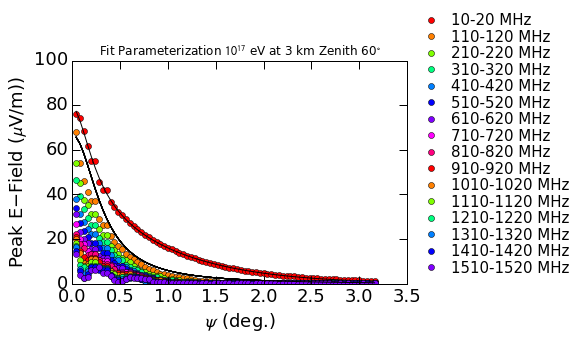

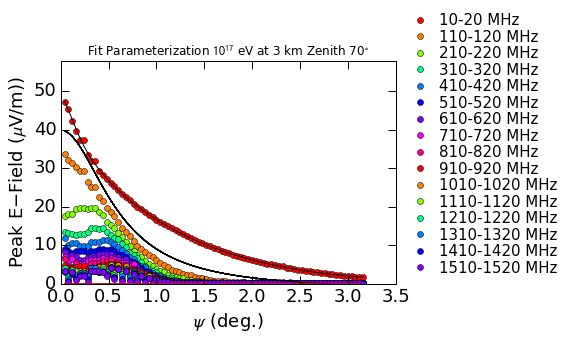

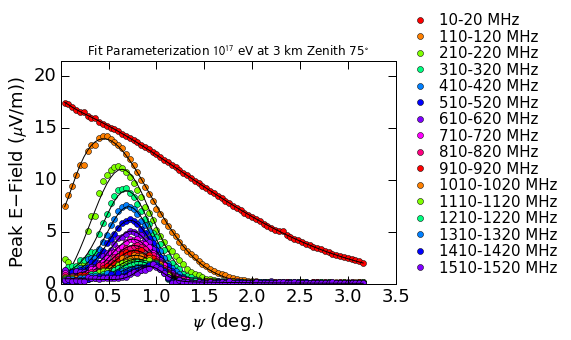

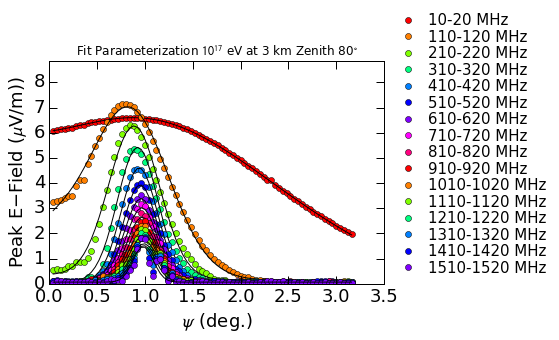

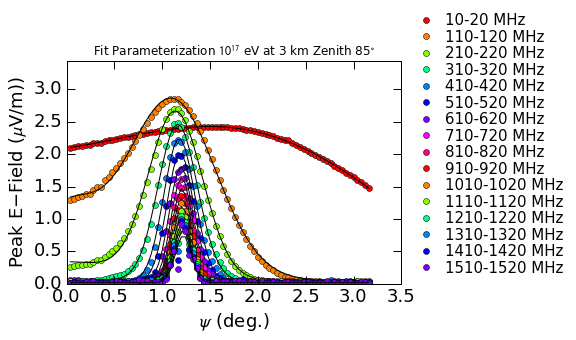

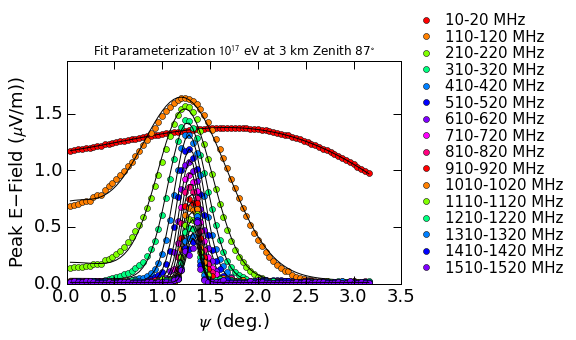

In [882]:
# Fit curves using a starting frequency of 25 MHz and varying the bandwidth.
# Using the initial parameters from the ANITA curve fit above 
# BUT finding the peak for each curve.
# NOTE: SHIFTING FROM 1.01 deg to peak in the efield.
# Fit fails if initial parameter for gauss_peak is not close
#### Working on this set for the 2 and 3 km altitude; fails for 1 km
i_bandwidth = 0
bandwidth = bandwidth_list[i_bandwidth]
print "Bandwidth : ", bandwidth

#i_ze = 5
#z = zenith_list[i_ze]

curve_fit_parameters = np.zeros((len(zenith_list), len(f_Lo_list), 6))
for i_ze in range(0, len(zenith_list)):

    for i_f_Lo in range(0,len(f_Lo_list)):
        f_Lo = f_Lo_list[i_f_Lo]
        E_1  =  max(epeak_array[i_ze][i_f_Lo][i_bandwidth])# V/m at ground level for 10^17 eV tau lepton.
        E_0 = epeak_array[i_ze][i_f_Lo][i_bandwidth][-1]   # V/m at ground level for 10^17 eV tau lepton.
        frac_gauss = E_1/E_0 # fraction of Gaussian peak ( 1-frac_gauss is lorentzian)
        gauss_peak = psi[np.where(max(epeak_array[i_ze][i_f_Lo][i_bandwidth]) == epeak_array[i_ze][i_f_Lo][i_bandwidth][:])[0][0]]      # degree. 
        if( i_f_Lo == 0):
            gauss_width = FWHM(psi, epeak_array[i_ze][i_f_Lo][i_bandwidth][:])
            width2 = gauss_peak
            p0 = [E_0, frac_gauss, gauss_peak, gauss_width, E_1, width2] # initial parameters for the curve fit.
        else:
            # Use the last gaussian and lorentzian widths to seed the fit.
            # The fit is sensitive to the individual frac_gauss, E_0, and E_1, but the widths are changing slowly.
       #     gauss_width = FWHM(psi, epeak_array[i_ze][i_f_Lo][i_bandwidth][:])
            #if( i_ze == 0):
            p0 = popt
            p0[2] = gauss_peak
        #if( frac_gauss < 0.05):
        #    p0[4] = E_1
   
        #print i_f_Lo, frac_gauss, p0
        #
        #pyp.plot(psi, lorentzian_gaussian_background_func(psi, *p0)*1e6,  'b')
        #pyp.plot(psi, epeak_array[i_ze,i_f_Lo, i_bandwidth,:]*1e6, 'o', color = bright_colors2[i_f_Lo%9], label="%d-%d MHz"%(int(f_Lo), int(f_Lo + bandwidth)))
        try:
            popt, pcov = curve_fit(lorentzian_gaussian_background_func, psi, epeak_array[i_ze, i_f_Lo,i_bandwidth,:], p0=p0)
        except:
            print "Fit failed, trying again", i_ze, i_f_Lo
            if( i_ze > 0):
                p0 = curve_fit_parameters[i_ze-1, i_f_Lo, :]
            else:
                p0 = [E_0, frac_gauss, gauss_peak, gauss_width, E_1, width2] 
                #p0[4] = E_1
            popt, pcov = curve_fit(lorentzian_gaussian_background_func, psi, epeak_array[i_ze, i_f_Lo,i_bandwidth,:], p0=p0)
        #popt = abs(popt)
        #popt, pcov = curve_fit(lorentzian_gaussian_background_func, psi, epeak_array[i_ze, i_f_Lo,i_bandwidth,:], p0=p0)
        curve_fit_parameters[i_ze, i_f_Lo, :] = popt
        if( i_f_Lo % 10 == 0):
            pyp.figure(i_ze+1)
            pyp.plot(psi, epeak_array[i_ze,i_f_Lo, i_bandwidth,:]*1e6, 'o', color = bright_colors2[i_f_Lo%9], label="%d-%d MHz"%(int(f_Lo), int(f_Lo + bandwidth)))
            #popt = abs(popt)
            pyp.plot(psi, lorentzian_gaussian_background_func(psi, *popt)*1e6,  'k')
        #if( i_f_Lo % 10 == 0):    
        #    print "FIT PARAMETERS: "
        #    print "_____________________"
        #print popt
        #    print "_____________________"
    pyp.figure(i_ze+1)
    print "Zenith", zenith_list[i_ze], i_ze
    pyp.title("Fit Parameterization $10^{17}$ eV at %d km Zenith %d$^{\circ}$"%(h, zenith_list[i_ze]), fontsize=12)
    print "Zenith", zenith_list[i_ze], i_ze
    pyp.ylabel("Peak E-Field ($\mu$V/m))")
    pyp.xlabel("$\psi$ (deg.)")
    pyp.xlim(0)
    pyp.ylim(0,1.2*epeak_array[i_ze,:, i_bandwidth,:].max()*1e6)
    pyp.legend(loc=[1.01,0.01])
    pyp.savefig(os.environ['TAU_ACC_DETECTOR_PLOTS_DIR'] + "/efield_eparms_altitude%dkm_ze%d.png"%(h,int(zenith_list[i_ze])) )

In [888]:
fit_file = open(os.environ['TAU_ACC_ZHAIRES_DIR']+'/curve_fits_%dkm.npz'%h, 'w')
np.savez(fit_file, curve_fit_parms=curve_fit_parameters, zenith_list=zenith_list, bandwidth=10., f_Lo_list = f_Lo_list)
fit_file.close()

In [884]:
h = 3
zenith_list = np.array([60, 70, 75, 80, 85, 87])
f_Lo_list = np.arange(10., 1610., 10.)
bandwidth_list = np.array([10.])

epeak_array = []
for z in zenith_list:
    psi, epeak_list = efield_vs_angle(h, z, f_Lo_list, bandwidth_list)
    epeak_array.append(epeak_list)
    
epeak_array = np.array(epeak_array)

Bandwidth :  10.0
[] [8]
0 8
Zenith 60 0
Zenith 60 0
[] [14]
0 14
Zenith 70 1
Zenith 70 1
[] [39]
0 39
Zenith 75 2
Zenith 75 2
Zenith 80 3
Zenith 80 3
Zenith 85 4
Zenith 85 4
Zenith 87 5
Zenith 87 5


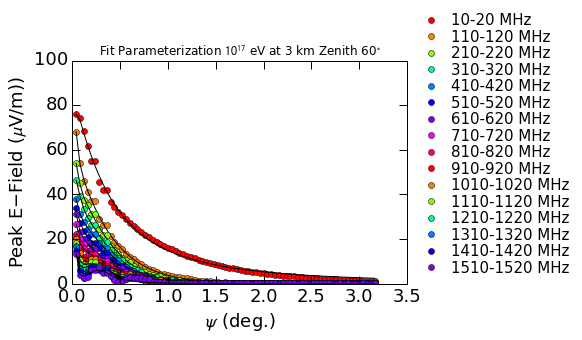

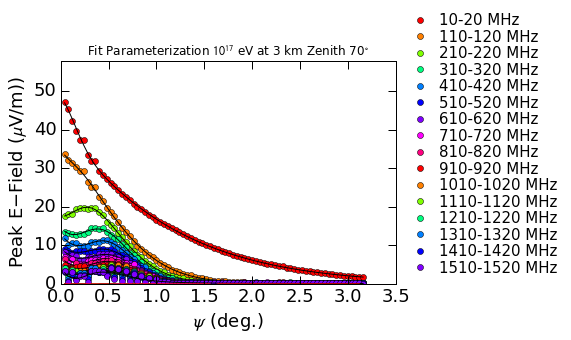

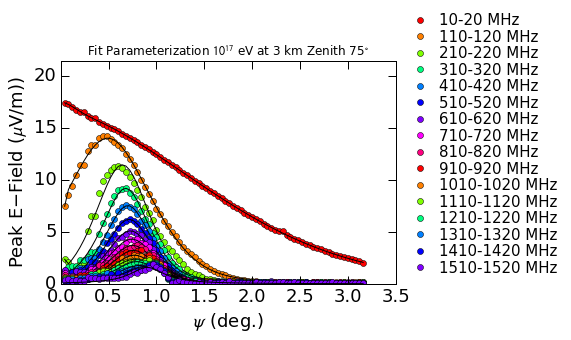

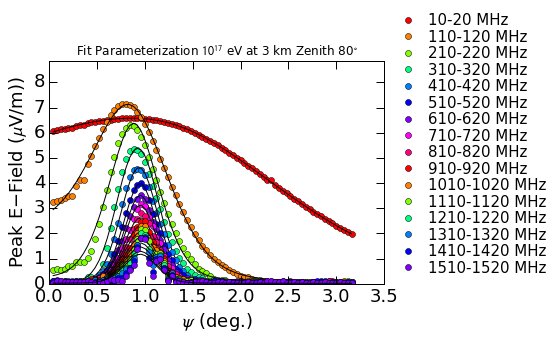

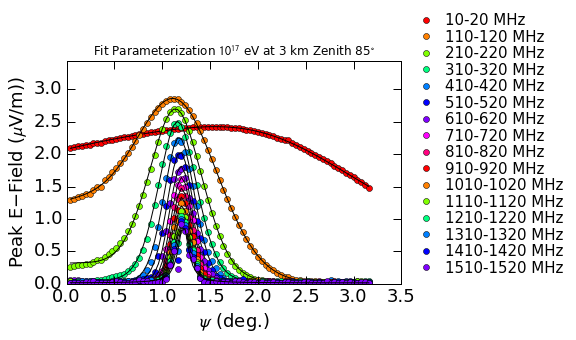

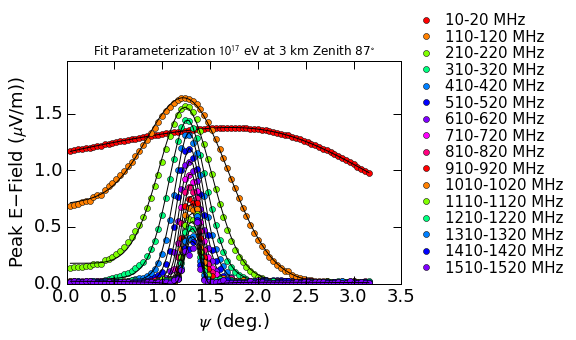

In [945]:
# Fit curves using a starting frequency of 25 MHz and varying the bandwidth.
# Using the initial parameters from the ANITA curve fit above 
# BUT finding the peak for each curve.
# NOTE: SHIFTING FROM 1.01 deg to peak in the efield.
# Fit fails if initial parameter for gauss_peak is not close
#### Working on this set for the 2 and 3 km altitude; fails for 1 km
i_bandwidth = 0
bandwidth = bandwidth_list[i_bandwidth]
print "Bandwidth : ", bandwidth

#i_ze = 5
#z = zenith_list[i_ze]

curve_fit_parameters = np.zeros((len(zenith_list), len(f_Lo_list), 6))
for i_ze in range(0, len(zenith_list)):

    for i_f_Lo in range(0,len(f_Lo_list)):
        f_Lo = f_Lo_list[i_f_Lo]
        E_0  =  max(epeak_array[i_ze][i_f_Lo][i_bandwidth])# V/m at ground level for 10^17 eV tau lepton.
        E_1 = epeak_array[i_ze][i_f_Lo][i_bandwidth][0]   # V/m at ground level for 10^17 eV tau lepton.
        frac_gauss = E_1/E_0 # fraction of Gaussian peak ( 1-frac_gauss is lorentzian)
        gauss_peak = psi[np.where(max(epeak_array[i_ze][i_f_Lo][i_bandwidth]) == epeak_array[i_ze][i_f_Lo][i_bandwidth][:])[0][0]]      # degree. 
        if( i_f_Lo == 0 ):
            gauss_width = FWHM(psi, epeak_array[i_ze][i_f_Lo][i_bandwidth][:])
            # extend interior lorentzian out to Cherenkov cone
            width2 = gauss_peak 
            #if( i_ze == 0):
            p0 = [E_0, 0., gauss_peak, gauss_width, E_1, width2] # initial parameters for the curve fit.
            #else:
            #    p0 = curve_fit_parameters[i_ze-1, i_f_Lo, :]
            #    p0[2]= gauss_peak

        else:
            # Use the last gaussian and lorentzian widths to seed the fit.
            # The fit is sensitive to the individual frac_gauss, E_0, and E_1, but the widths are changing slowly.
       #     gauss_width = FWHM(psi, epeak_array[i_ze][i_f_Lo][i_bandwidth][:])
            #if( i_ze == 0):
            #if( i_ze == 0):
            p0 = popt
            #else:
            #    p0 = curve_fit_parameters[i_ze-1, i_f_Lo, :]
            #p0[2] = gauss_peak
            #p0[0] = E_0
            #p0[5] = gauss_width
            #p0[4] = E_1
            #p0 = curve_fit_parameters[i_ze-1, i_f_Lo, :]

            #p0[2] = gauss_peak
        #if( frac_gauss < 0.05):
        #    p0[4] = E_1
   
        #print i_f_Lo, frac_gauss, p0
        #
        #pyp.plot(psi, lorentzian_gaussian_background_func(psi, *p0)*1e6,  'b')
        #pyp.plot(psi, epeak_array[i_ze,i_f_Lo, i_bandwidth,:]*1e6, 'o', color = bright_colors2[i_f_Lo%9], label="%d-%d MHz"%(int(f_Lo), int(f_Lo + bandwidth)))
        bounds = [-np.inf,0,-10.,0,-np.inf,0], [np.inf,2.0,10.,np.inf,np.inf,np.inf]
        try:
            popt, pcov = curve_fit(lorentzian_gaussian_background_func, psi, epeak_array[i_ze, i_f_Lo,i_bandwidth,:], p0=p0, bounds=bounds)
            #popt, pcov = curve_fit(lorentzian_gaussian_background_func, psi, epeak_array[i_ze, i_f_Lo,i_bandwidth,:], p0=p0)
        except:
            print "Fit failed, trying again", i_ze, i_f_Lo
            if( i_ze > 0):
                p0 = curve_fit_parameters[i_ze-1, i_f_Lo, :]
                p0[0] = E_0
                p0[4] = E_1
            else:
                p0 = [E_0, frac_gauss, gauss_peak, gauss_width, E_1, width2] 
                #p0[4] = E_1
            popt, pcov = curve_fit(lorentzian_gaussian_background_func, psi, epeak_array[i_ze, i_f_Lo,i_bandwidth,:], p0=p0)
        
        #popt = abs(popt)
        #popt, pcov = curve_fit(lorentzian_gaussian_background_func, psi, epeak_array[i_ze, i_f_Lo,i_bandwidth,:], p0=p0)
        curve_fit_parameters[i_ze, i_f_Lo, :] = popt
        if( i_f_Lo % 10 == 0):
            pyp.figure(i_ze+1)
            pyp.plot(psi, epeak_array[i_ze,i_f_Lo, i_bandwidth,:]*1e6, 'o', color = bright_colors2[i_f_Lo%9], label="%d-%d MHz"%(int(f_Lo), int(f_Lo + bandwidth)))
            #popt = abs(popt)
            pyp.plot(psi, lorentzian_gaussian_background_func(psi, *popt)*1e6,  'k')
        #if( i_f_Lo % 10 == 0):    
        #    print "FIT PARAMETERS: "
        #    print "_____________________"
        #    print popt
        #    print "_____________________"
    pyp.figure(i_ze+1)
    print "Zenith", zenith_list[i_ze], i_ze
    pyp.title("Fit Parameterization $10^{17}$ eV at %d km Zenith %d$^{\circ}$"%(h, zenith_list[i_ze]), fontsize=12)
    print "Zenith", zenith_list[i_ze], i_ze
    pyp.ylabel("Peak E-Field ($\mu$V/m))")
    pyp.xlabel("$\psi$ (deg.)")
    pyp.xlim(0)
    pyp.ylim(0,1.2*epeak_array[i_ze,:, i_bandwidth,:].max()*1e6)
    pyp.legend(loc=[1.01,0.01])
    pyp.savefig(os.environ['TAU_ACC_DETECTOR_PLOTS_DIR'] + "/efield_eparms_altitude%dkm_ze%d.png"%(h,int(zenith_list[i_ze])) )

In [946]:
fit_file = open(os.environ['TAU_ACC_ZHAIRES_DIR']+'/curve_fits_%dkm.npz'%h, 'w')
np.savez(fit_file, curve_fit_parms=curve_fit_parameters, zenith_list=zenith_list, bandwidth=10., f_Lo_list = f_Lo_list)
fit_file.close()

In [845]:
# This stops the notebook running
# Things below this point are more experimental.
print some_undefined_variable

NameError: name 'some_undefined_variable' is not defined

Starting Bandwidth :  10.0
INITIAL PARAMETERS: 
_____________________
[3.3741539060264404e-05, 1.0, 0.040000000000000001, 3.0, 3.3741539060264404e-05, 3.0]
_____________________
FIT PARAMETERS: 
_____________________
[  1.16712726e-03   7.36716016e+02   2.06991737e+00   2.80609885e+02
   1.16935452e-03   8.17206115e+02]
_____________________
INITIAL PARAMETERS: 
_____________________
[9.1221910758708884e-06, 0.99582003456168733, 0.44, 3.0, 9.0840606324520635e-06, 3.0]
_____________________


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.

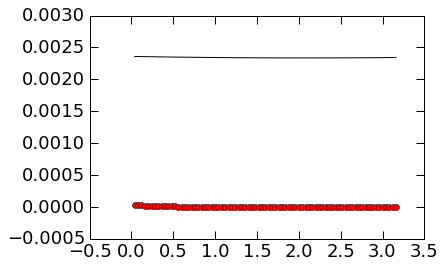

In [951]:
# Fit curves using a starting frequency of 25 MHz and varying the bandwidth.
# Using the initial parameters from the ANITA curve fit above 
# BUT finding the peak for each curve.
# NOTE: SHIFTING FROM 1.01 deg to peak in the efield.
# Fit fails if initial parameter for gauss_peak is not close
i_bandwidth = 0
bandwidth = bandwidth_list[i_bandwidth]
print "Starting Bandwidth : ", bandwidth

i_f_Lo = 50
f_Lo = f_Lo_list[i_f_Lo]
#curve_fit_parameters = np.zeros((len(zenith_list), 6))

for i_ze in range(0,len(zenith_list)):
    z = zenith_list[i_ze]

    E_0  =  max(epeak_array[i_ze][i_f_Lo][i_bandwidth])# V/m at ground level for 10^17 eV tau lepton.
    E_1 = epeak_array[i_ze][i_f_Lo][i_bandwidth][0]   # V/m at ground level for 10^17 eV tau lepton.
    frac_gauss = E_1/E_0 # fraction of Gaussian peak ( 1-frac_gauss is lorentzian)
    gauss_peak = psi[np.where(max(epeak_array[i_ze][i_f_Lo][i_bandwidth]) == epeak_array[i_ze][i_f_Lo][i_bandwidth][:])[0][0]]      # degree. 
    if( frac_gauss < 0.5):
        gauss_width = FWHM(psi, epeak_array[i_ze][i_f_Lo][i_bandwidth][:])
        #frac_gauss = gauss_width / 4.0# degrees
        width2 = 3.00
    else:
        gauss_width = 3.00
        width2 = 3.00    # degrees

    p0 = [E_0, frac_gauss, gauss_peak, gauss_width, E_1, width2] # initial parameters for the curve fit.
    print "INITIAL PARAMETERS: "
    print "_____________________"
    print p0
    print "_____________________"
    popt, pcov = curve_fit(lorentzian_gaussian_background_func, psi, epeak_array[i_ze, i_f_Lo,i_bandwidth,:],p0=p0)
    pyp.plot(psi, epeak_array[i_ze,i_f_Lo, i_bandwidth,:], 'o', color = bright_colors2[i_ze%9], label="$%d^{\circ}$"%(int(z)))
    popt = abs(popt)
    pyp.plot(psi, lorentzian_gaussian_background_func(psi, *popt),  'k')
    #curve_fit_parameters[i_ze, :] = popt
    print "FIT PARAMETERS: "
    print "_____________________"
    print popt
    print "_____________________"
pyp.title("Fit Parameterization $10^{17}$ eV, $f_{low}$ %d MHz"%(int(f_Lo_list[i_f_Lo])), fontsize=12)
pyp.ylabel("Peak E-Field (V/m))")
pyp.xlabel("$\psi$ (deg.)")
pyp.xlim(0)
pyp.ylim(0)
pyp.legend(loc=[1.01,0.01])
#pyp.savefig(os.environ['TAU_ACC_DETECTOR_PLOTS_DIR'] + "/efield_eparms_%dMHz_altitude%dkm_ze%d.png"%(int(f_Lo_list[i_f_Lo]),h,z) )

In [950]:
E0_interp = interp1d(zenith_list,curve_fit_parameters[:,0, 0], kind='cubic')
frac_gauss_interp = interp1d(zenith_list,curve_fit_parameters[:,0, 1], )
gauss_peak_interp = interp1d(zenith_list,curve_fit_parameters[:,0, 2])
gauss_width_interp = interp1d(zenith_list,curve_fit_parameters[:,0, 3])
E1_interp = interp1d(zenith_list,curve_fit_parameters[:,0, 4])
width2_interp = interp1d(zenith_list,curve_fit_parameters[:,0, 5])
ze_interp = np.arange(60, 87, 0.1)

IndexError: too many indices for array

In [953]:
pyp.plot(zenith_list, curve_fit_parameters[:,0,0], 'o')
pyp.plot(ze_interp, E0_interp(ze_interp))

IndexError: too many indices for array

In [954]:
pyp.plot(zenith_list, curve_fit_parameters[:,0,1], 'o')
pyp.plot(ze_interp, frac_gauss_interp(ze_interp))

IndexError: too many indices for array

In [955]:
pyp.plot(zenith_list, curve_fit_parameters[:,0,2], 'o')
pyp.plot(ze_interp, gauss_peak_interp(ze_interp))

IndexError: too many indices for array

In [ ]:
pyp.plot(zenith_list, curve_fit_parameters[:,0,3], 'o')
pyp.plot(ze_interp, gauss_width_interp(ze_interp))

In [ ]:
pyp.plot(zenith_list, curve_fit_parameters[:,0,4], 'o')
pyp.plot(ze_interp, E1_interp(ze_interp))

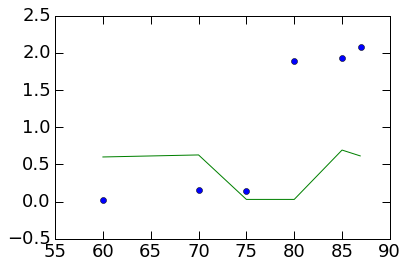

In [948]:
pyp.plot(zenith_list, curve_fit_parameters[:,0,5],'o')
pyp.plot(ze_interp, width2_interp(ze_interp))


In [949]:
# Fit curves using a starting frequency of 25 MHz and varying the bandwidth.
# Using the initial parameters from the ANITA curve fit above 
# BUT finding the peak for each curve.
# NOTE: SHIFTING FROM 1.01 deg to peak in the efield.
# Fit fails if initial parameter for gauss_peak is not close
i_bandwidth = 0
bandwidth = bandwidth_list[i_bandwidth]
print "Starting Frequency : ", bandwidth

i_f_Lo = 8
f_Lo = f_Lo_list[i_f_Lo]
curve_fit_parameters = np.zeros((len(zenith_list), 6))

for i_ze in range(0,len(zenith_list)):
    z = zenith_list[i_ze]

    E_0  =  max(epeak_array[i_ze][i_f_Lo][i_bandwidth])# V/m at ground level for 10^17 eV tau lepton.
    E_1 = epeak_array[i_ze][i_f_Lo][i_bandwidth][0]   # V/m at ground level for 10^17 eV tau lepton.
    frac_gauss = E_1/E_0 # fraction of Gaussian peak ( 1-frac_gauss is lorentzian)
    gauss_peak = psi[np.where(max(epeak_array[i_ze][i_f_Lo][i_bandwidth]) == epeak_array[i_ze][i_f_Lo][i_bandwidth][:])[0][0]]      # degree. 
    if( frac_gauss < 0.5):
        gauss_width = FWHM(psi, epeak_array[i_ze][i_f_Lo][i_bandwidth][:])
        #frac_gauss = gauss_width / 4.0# degrees
        width2 = 0.05
    else:
        gauss_width = 3.00
        width2 = 0.05   # degrees
    p0 = [E_0, frac_gauss, gauss_peak, gauss_width, E_1, width2] # initial parameters for the curve fit.
    #print "INITIAL PARAMETERS: "
    #print "_____________________"
    #print p0
    #print "_____________________"
    popt, pcov = curve_fit(lorentzian_gaussian_background_func, psi, epeak_array[i_ze, i_f_Lo,i_bandwidth,:], p0=p0)
    pyp.plot(psi, epeak_array[i_ze,i_f_Lo, i_bandwidth,:], 'o', color = bright_colors2[i_ze%9], label="$%d^{\circ}$"%(int(z)))
    pyp.plot(psi, lorentzian_gaussian_background_func(psi, *popt),  'k')
    curve_fit_parameters[i_ze, :] = popt

ze = 65.
E0_interp = interp1d(zenith_list,curve_fit_parameters[:, 0], kind='cubic')
frac_gauss_interp = interp1d(zenith_list,curve_fit_parameters[:, 1], )
gauss_peak_interp = interp1d(zenith_list,curve_fit_parameters[:, 2])
gauss_width_interp = interp1d(zenith_list,curve_fit_parameters[:, 3])
E1_interp = interp1d(zenith_list,curve_fit_parameters[:, 4])
width2_interp = interp1d(zenith_list,curve_fit_parameters[:, 5])

interp_parms = [E0_interp(ze), frac_gauss_interp(ze), gauss_peak_interp(ze),
               gauss_width_interp(ze), E1_interp(ze), width2_interp(ze)]
pyp.plot(psi, lorentzian_gaussian_background_func(psi, *interp_parms), 'k--', linewidth=3)

pyp.title("Fit Parameterization $10^{17}$ eV, $f_{low}$ %d MHz"%(int(f_Lo_list[i_f_Lo])), fontsize=12)
pyp.ylabel("Peak E-Field (V/m))")
pyp.xlabel("$\psi$ (deg.)")
pyp.xlim(0)
pyp.ylim(0)
pyp.legend(loc=[1.01,0.01])
#pyp.savefig(os.environ['TAU_ACC_DETECTOR_PLOTS_DIR'] + "/efield_eparms_%dMHz_altitude%dkm_ze%d.png"%(int(f_Lo_list[i_f_Lo]),h,z) )

Starting Frequency :  10.0


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.

In [ ]:
### The above works okay. Now just need to output the curve fit parameters to a file


# Fit curves using a starting frequency of 25 MHz and varying the bandwidth.
# Using the initial parameters from the ANITA curve fit above 
# BUT finding the peak for each curve.
# NOTE: SHIFTING FROM 1.01 deg to peak in the efield.
# Fit fails if initial parameter for gauss_peak is not close
i_bandwidth = 0
bandwidth = bandwidth_list[i_bandwidth]
print "Bandwidth : ", bandwidth

curve_fit_parameters = np.zeros((len(f_Lo_list), len(zenith_list), 6))
for i_f_Lo in range(0, len(f_Lo_list)):
    print "Starting Frequency: ", f_Lo_list[i_f_Lo]
    pyp.figure()
    for i_ze in range(0,len(zenith_list)):
        z = zenith_list[i_ze]

        E_0  =  max(epeak_array[i_ze][i_f_Lo][i_bandwidth])# V/m at ground level for 10^17 eV tau lepton.
        E_1 = epeak_array[i_ze][i_f_Lo][i_bandwidth][0]   # V/m at ground level for 10^17 eV tau lepton.
        frac_gauss = E_1/E_0 # fraction of Gaussian peak ( 1-frac_gauss is lorentzian)
        gauss_peak = psi[np.where(max(epeak_array[i_ze][i_f_Lo][i_bandwidth]) == epeak_array[i_ze][i_f_Lo][i_bandwidth][:])[0][0]]      # degree. 
        if( frac_gauss < 0.5):
            gauss_width = FWHM(psi, epeak_array[i_ze][i_f_Lo][i_bandwidth][:])
            #frac_gauss = gauss_width / 4.0# degrees
            width2 = 0.05
        else:
            gauss_width = 3.00
            width2 = 0.05   # degrees
        p0 = [E_0, frac_gauss, gauss_peak, gauss_width, E_1, width2] # initial parameters for the curve fit.
        #print "INITIAL PARAMETERS: "
        #print "_____________________"
        #print p0
        #print "_____________________"
        popt, pcov = curve_fit(lorentzian_gaussian_background_func, psi, epeak_array[i_ze, i_f_Lo,i_bandwidth,:], p0=p0)
        pyp.plot(psi, epeak_array[i_ze,i_f_Lo, i_bandwidth,:], 'o', color = bright_colors2[i_ze%9], label="$%d^{\circ}$"%(int(z)))
        pyp.plot(psi, lorentzian_gaussian_background_func(psi, *popt),  'k')
        curve_fit_parameters[i_f_Lo, i_ze, :] = popt

    ze = 65.
    E0_interp = interp1d(zenith_list,curve_fit_parameters[i_f_Lo, :, 0], kind='cubic')
    frac_gauss_interp = interp1d(zenith_list,curve_fit_parameters[i_f_Lo, :, 1], )
    gauss_peak_interp = interp1d(zenith_list,curve_fit_parameters[i_f_Lo, :, 2])
    gauss_width_interp = interp1d(zenith_list,curve_fit_parameters[i_f_Lo, :, 3])
    E1_interp = interp1d(zenith_list,curve_fit_parameters[i_f_Lo, :, 4])
    width2_interp = interp1d(zenith_list,curve_fit_parameters[i_f_Lo, :, 5])

    interp_parms = [E0_interp(ze), frac_gauss_interp(ze), gauss_peak_interp(ze),
                   gauss_width_interp(ze), E1_interp(ze), width2_interp(ze)]
    pyp.plot(psi, lorentzian_gaussian_background_func(psi, *interp_parms), 'k--', linewidth=3)

    pyp.title("Fit Parameterization $10^{17}$ eV, $f_{low}$ %d MHz"%(int(f_Lo_list[i_f_Lo])), fontsize=12)
    pyp.ylabel("Peak E-Field (V/m))")
    pyp.xlabel("$\psi$ (deg.)")
    pyp.xlim(0)
    pyp.ylim(0)
    pyp.legend(loc=[1.01,0.01])
#pyp.savefig(os.environ['TAU_ACC_DETECTOR_PLOTS_DIR'] + "/efield_eparms_%dMHz_altitude%dkm_ze%d.png"%(int(f_Lo_list[i_f_Lo]),h,z) )